In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import adelie as gl
from adelie.group_elnet import *
from adelie.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
import scipy

In [3]:
def analyze_base(out):
    diag = out['diagnostic']

    if out['error'] != '':
        logging.warning(out['error'])

    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")
    
    gl_diag = diag['time_group_elnet']
    time_strong = [np.sum(d['time_strong_cd']) for d in gl_diag]
    time_active = [np.sum(d['time_active_cd']) for d in gl_diag]
    logging.debug(f"Time Strong Total:  {np.sum(time_strong)}")
    logging.debug(f"Time Active Total:  {np.sum(time_active)}")

    logging.debug(f"Number of lambdas:  {len(out['lmdas'])}")

def analyze_cov(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_elnet']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_elnet']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Loop Number")
            ax.set_ylabel("Time (s)")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    axes[0].plot(diag['n_cds'], marker='.')
    axes[0].set_title("Number of CDs")
    axes[0].set_xlabel("Basil Iteration")
    axes[0].set_ylabel("Number of CDs")
    axes[1].plot(-np.log(out['lmdas']), out['rsqs'], marker='.')
    axes[1].set_title("$R^2$")
    axes[1].set_xlabel("$-\\log(\\lambda)$")
    axes[1].set_ylabel("$R^2$")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    active_count = [out['betas'][:, j].count_nonzero() for j in range(out['betas'].shape[-1])]
    axes[0].plot(active_count, marker='.')
    axes[0].set_title("Active Count")
    axes[0].set_xlabel("$\\lambda$ index")
    axes[0].set_ylabel("Active count")

    axes[1].plot(out['diagnostic']['strong_sizes_total'], marker='.')
    axes[1].set_title("Strong Count")
    axes[1].set_xlabel("$\\lambda$ index")
    axes[1].set_ylabel("Strong count")
    plt.show()
    
    _, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
    for j in tqdm(range(out['betas'].shape[0])):
        beta_j = out['betas'][j]
        if beta_j.count_nonzero() > 0:
            axes.plot(-np.log(out['lmdas']), beta_j.todense().reshape((-1,1)))
    axes.set_title('Non-zero $\\beta$ Profile')
    axes.set_xlabel('$-\log(\lambda)$')
    axes.set_ylabel('$\\beta$')
    plt.show()


In [4]:
n = 10000
p = 16
n_groups = int(p/10)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_elnet_data(
    n, p, n_groups, rho=0.0, svd_transform=False, group_split_type="even",
).values()

In [5]:
alpha = 1
penalty = np.sqrt(group_sizes)

In [6]:
# naive
out_naive = group_basil(
    X, y, groups, group_sizes, 
    alpha=alpha,
    penalty=penalty,
    method='naive', 
    max_n_cds=int(1e6), 
    n_lambdas_iter=5,
    use_strong_rule=True,
    verbose_diagnostic=False,
)
diag_naive = out_naive['diagnostic']

DEBUG:root:Time Init:          3.83e-05
DEBUG:root:Time Init Fit:      0.00011228900000000001
DEBUG:root:Time Screen:        0.0014616450000000001
DEBUG:root:Time Fit:           0.004360593
DEBUG:root:Time KKT:           0.005584699
DEBUG:root:Time Transform:     0.004753257
DEBUG:root:Time Untransform:   0.002574133
DEBUG:root:Time Strong Total:  0.002749421
DEBUG:root:Time Active Total:  0.0013357440000000003
DEBUG:root:Number of lambdas:  51
100%|██████████| 11/11 [00:00<00:00, 2034.36it/s]


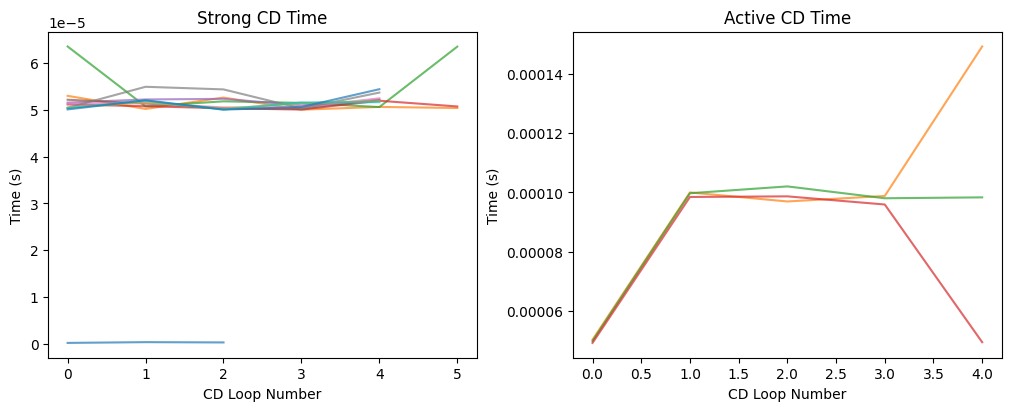

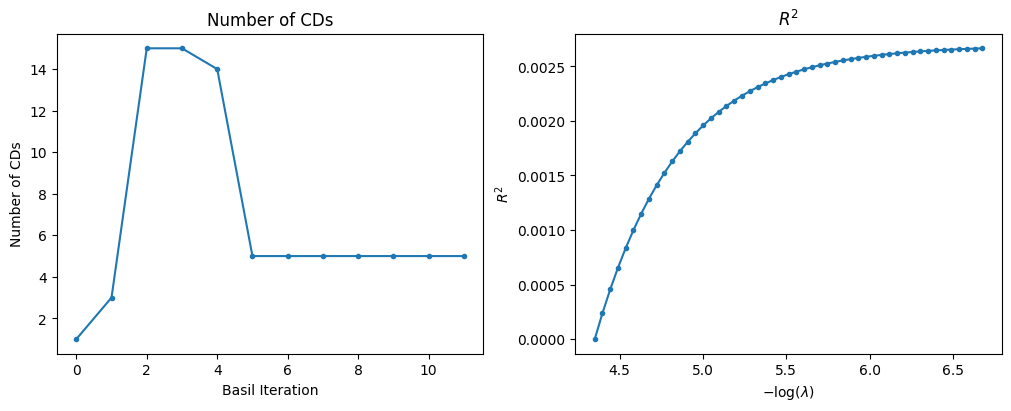

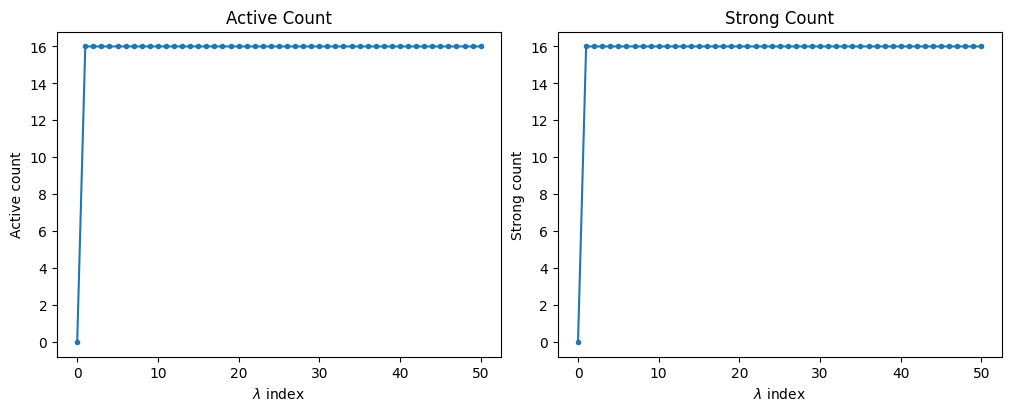

100%|██████████| 16/16 [00:00<00:00, 1889.01it/s]


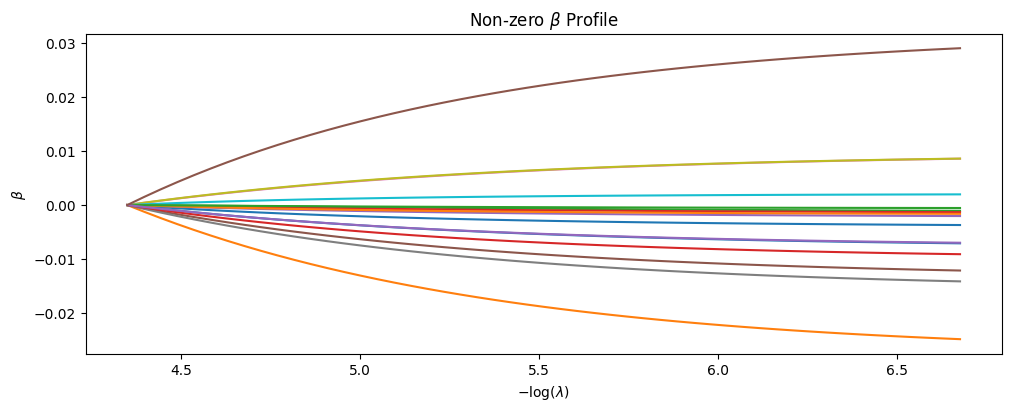

In [7]:
analyze_naive(out_naive)

In [9]:
def compute_abs_grad(
    X, y, groups, group_sizes, beta, lmda, alpha, penalty
):
    if isinstance(beta, scipy.sparse._csc.csc_matrix):
        beta = np.ravel(beta.todense())
    grad = X.T @ (y - X @ beta) - lmda * (1 - alpha) * np.repeat(penalty, group_sizes) * beta
    abs_grad = np.array([
        np.linalg.norm(grad[g:g+gs])
        for g, gs in zip(groups, group_sizes)
    ])
    return abs_grad
    
def plot_abs_grad(abs_grad, lmda, alpha, penalty):
    abs_grad_scaled = abs_grad / (lmda * alpha * penalty)
    abs_grad_scaled = abs_grad_scaled[abs_grad_scaled > 1]
    plt.hist(abs_grad_scaled-1, bins=30)
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel("$\|X_i^\\top (y-X\\beta) - \lambda (1-\\alpha) w_i \\beta_i\|_2 / \lambda - 1$")
    plt.ylabel("Counts")
    plt.title("Error in KKT Check")
    plt.show()

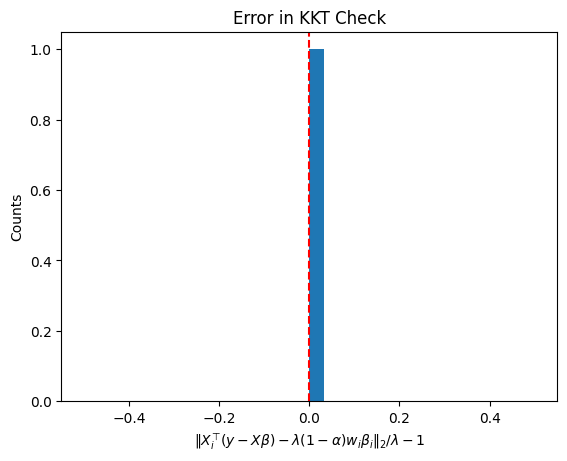

In [10]:
i = -1
beta = out_naive['betas'][:, i]
lmda = out_naive['lmdas'][i]
abs_grad = compute_abs_grad(X,y,groups,group_sizes,beta,lmda,alpha,penalty)
plot_abs_grad(abs_grad, lmda, alpha, penalty)

In [11]:
def group_edpp(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    grad = X.T @ y
    abs_grad = np.array([
        np.linalg.norm(grad[g : g + gs]) / pg
        for g, gs, pg in zip(groups, group_sizes, penalty)
    ])
    i_star = np.argmax(abs_grad)
    X_star = X[:, groups[i_star] : groups[i_star] + group_sizes[i_star]]

    X_norms = np.array([
        np.linalg.norm(X[:, g : g + gs])
        for g, gs in zip(groups, group_sizes)
    ])
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]

        theta_k = (y - X @ b_k) / lmda_k
        v1_k = y / lmda_k - theta_k if k > 0 else X_star @ (X_star.T @ y)
        v2_k = y / lmda_k1 - theta_k
        v1_k_norm = np.linalg.norm(v1_k)
        v2_k_perp = v2_k - (v1_k @ v2_k) / (v1_k_norm ** 2) * v1_k
        grad = X.T @ (theta_k + 0.5 * v2_k_perp)
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        
        thresh = penalty - 0.5 * np.linalg.norm(v2_k_perp) * X_norms
        
        n_rejects[k] = np.sum(abs_grad <= thresh)
        
    return n_rejects
    
def group_ssr(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]
        
        grad = X.T @ (y - X @ b_k) - lmda_k * (1 - alpha) * np.repeat(penalty, group_sizes) * b_k
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        n_rejects[k] = np.sum(abs_grad / (alpha * penalty) <= (2 * lmda_k1 - lmda_k))
        
    return n_rejects

In [12]:
out_edpp = group_edpp(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

out_ssr = group_ssr(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

print(out_edpp)
print(out_ssr)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [13]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)

    def generate_penalty(i):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm = cp.norm(beta[gb:ge])
        return penalty[i] * (alpha * bi_norm + ((1-alpha) / 2) * cp.sum_squares(beta[gb:ge]))
    penalty = [generate_penalty(i) for i in range(len(groups))]
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * cp.sum(penalty))
    prob = cp.Problem(objective)
    result = prob.solve(solver=cp.MOSEK)
    return beta.value 


In [73]:
b_lmdas = 0#-20
e_lmdas = len(out_naive['lmdas'])
lmdas = np.array(out_naive['lmdas'][b_lmdas:e_lmdas])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=alpha, penalty=penalty, lmda=lmdas[i])

100%|██████████| 51/51 [00:27<00:00,  1.87it/s]


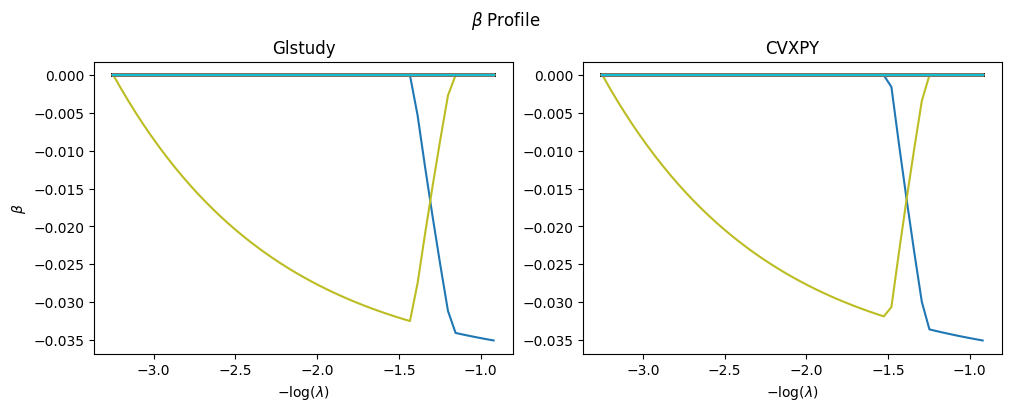

In [74]:
_, axes = plt.subplots(1, 2, layout='compressed', figsize=(10, 4))
for j in range(cvxpy_betas.shape[0]):
    beta_j = out_naive['betas'][j, b_lmdas:e_lmdas]
    axes[0].plot(-np.log(lmdas), beta_j.todense().reshape((-1,1)))
    axes[0].set_title('Glstudy')
    axes[0].set_ylabel('$\\beta$')
    axes[0].set_xlabel('$-\log(\lambda)$')
    axes[1].plot(-np.log(lmdas), cvxpy_betas[j])
    axes[1].set_title('CVXPY')
    axes[1].set_xlabel('$-\log(\lambda)$')
plt.suptitle('$\\beta$ Profile')
plt.show()

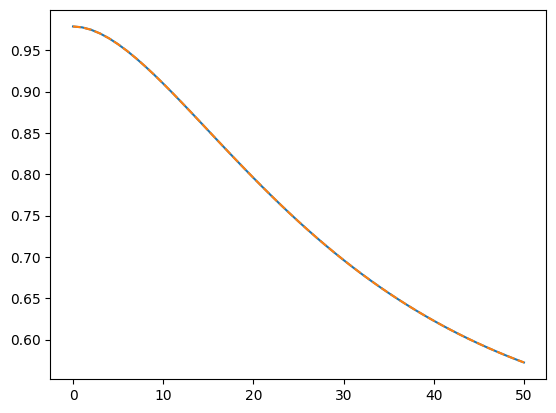

In [75]:
my_betas = np.array(out_naive['betas'][:, b_lmdas:e_lmdas].todense())
my_objs = [
    gl.group_elnet_objective(X, y, groups, group_sizes, alpha, penalty, lmdas[i], my_betas[:, i])
    for i in range(my_betas.shape[-1])
]
cvxpy_objs = [
    gl.group_elnet_objective(X, y, groups, group_sizes, alpha, penalty, lmdas[i], np.copy(cvxpy_betas[:, i]))
    for i in range(my_betas.shape[-1])
]
plt.plot(my_objs, linestyle='-')
plt.plot(cvxpy_objs, linestyle='--')